In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

from utility import (
    getPossibleActions,
    performAction,
    ageEntanglements,
    generateEntanglement,
    jains_index,
    min_max_fairness,
    rolling_average
)


    
def print_greedy_summary(results_dict, goal_edges):
    """
    Print summary statistics for greedy policy simulation results.
    Accepts the dictionary structure outputted by simulate_policy_multi_greedy().
    """
    for policy, res in results_dict.items():
        print(f"\n--- Summary for policy: {policy.upper()} ---")
        total_time = res['total_timesteps']
        goals_achieved = res['goals_achieved']
        final_edrs = {g: goals_achieved[g] / max(1, total_time) for g in goal_edges}
        
        # Print per-goal EDR
        for g in goal_edges:
            print(f"  Goal {g} EDR: {final_edrs[g]:.4f}")
        
        # Print totals
        throughput = sum(final_edrs.values())
        fairness = jains_index(final_edrs)
        print(f"  Total Throughput: {throughput:.4f}")
        print(f"  Jain's Fairness Index: {fairness:.4f}")
        print(f"  Aged-Out Ratio (last 1000 steps): {np.mean(res['aged'][-1000:]):.4f}")
        print(f"  Action Decision Ratio (last 1000 steps): {np.mean(res['actions'][-1000:]):.4f}")


def dict_to_state(state_dict):
    return [(edge, age) for edge, age in sorted(state_dict.items())]

def state_to_dict(state_list):
    return {edge: age for edge, age in state_list}

import random

def choose_action(policy_type, actions, goal_success_counts, total_timesteps, pSwap):
    if not actions:
        return ([], None)

    if policy_type == 'random':
        return random.choice(actions)

    if policy_type == 'spf':
        min_length = min(len(path) for path, _ in actions)
        shortest_actions = [action for action in actions if len(action[0]) == min_length]
        return random.choice(shortest_actions)

    if policy_type == 'lowest_edr':
        return min(actions, key=lambda x: goal_success_counts.get(x[1], 0) / max(1, total_timesteps))

    if policy_type == 'utility':
        def utility(action):
            path, goal = action
            if not goal or not path:
                return 0
            rate = pSwap ** (len(path) - 1)
            edr = goal_success_counts.get(goal, 0) / max(1, total_timesteps)
            return np.log(1+rate / max(1e-4, edr))
        return max(actions, key=utility)

    return ([], None)


def simulate_policy_multi_greedy(edges, goalEdges, pSwap, pGen, maxAge, policy_type, num_steps=10000):
    total_timesteps = 0
    goal_success_counts = {goal: 0 for goal in goalEdges}
    goal_attempt_counts = {goal: 0 for goal in goalEdges}
    edr_history = {goal: [] for goal in goalEdges}
    fairness_history = {'jains_index': [], 'min_max_ratio': [], 'cv': []}
    aged_out_history = []
    action_ratio_history = []

    current_state = {edge: -1 for edge in edges}

    for step in range(num_steps):
        state_list = dict_to_state(current_state)
        possible_actions = getPossibleActions(state_list, goalEdges)
        valid_actions = [a for a in possible_actions if a[0]]

        best_action = choose_action(policy_type, valid_actions, goal_success_counts, total_timesteps, pSwap)

        action_taken = best_action and best_action != ([], None)
        action_ratio_history.append(1.0 if valid_actions and action_taken else 0.0)

        if action_taken:
            consumed_edges, goal = best_action
            goal_attempt_counts[goal] += 1
            if random.random() < pSwap ** (len(consumed_edges) - 1):
                goal_success_counts[goal] += 1

        num_existing_before = sum(1 for _, age in state_list if age >= 0)
        state_list = performAction(best_action, state_list)
        state_list = ageEntanglements(state_list, maxAge)
        num_existing_after = sum(1 for _, age in state_list if age >= 0)
        num_aged_out = num_existing_before - num_existing_after

        state_list = generateEntanglement(state_list, pGen)
        current_state = state_to_dict(state_list)
        num_generated = sum(1 for _, age in state_list if age == 1)

        aged_out_ratio = num_aged_out / (num_aged_out + num_generated) if num_generated > 0 else 0.0
        aged_out_history.append(aged_out_ratio)

        total_timesteps += 1
        current_edrs = {goal: goal_success_counts[goal] / total_timesteps for goal in goalEdges}
        for goal in goalEdges:
            edr_history[goal].append(current_edrs[goal])

        jains = jains_index(current_edrs)
        minmax = min_max_fairness(current_edrs)
        cv = np.std(list(current_edrs.values())) / max(1e-6, np.mean(list(current_edrs.values())))
        fairness_history['jains_index'].append(jains)
        fairness_history['min_max_ratio'].append(minmax)
        fairness_history['cv'].append(cv)
    return edr_history, fairness_history, goal_success_counts, goal_attempt_counts, total_timesteps, aged_out_history, action_ratio_history

def plot_greedy_policy_results(results, goalEdges):
    print_greedy_summary(results, goal_edges)
    fig, axs = plt.subplots(2, 3, figsize=(22, 12))
    policy_colors = {'spf': 'blue', 'random': 'green', 'lowest_edr': 'purple', 'utility': 'red'}

    # --- EDR Evolution ---
    for policy, res in results.items():
        for i, goal in enumerate(goalEdges):
            linestyle = '-' if i == 0 else '--'
            axs[0][0].plot(
                res['edr_history'][goal],
                label=f'{policy} - Goal {goal}',
                color=policy_colors.get(policy),
                linestyle=linestyle
            )
    axs[0][0].set_title("EDR Evolution Over Time")
    axs[0][0].set_xlabel("Timestep")
    axs[0][0].set_ylabel("EDR")
    axs[0][0].set_ylim(0, 1.05)
    axs[0][0].legend()
    axs[0][0].grid(True)

    # --- Jain's Fairness ---
    for policy, res in results.items():
        axs[0][1].plot(
            res['fairness_history']['jains_index'],
            label=policy,
            color=policy_colors.get(policy)
        )
    axs[0][1].set_title("Jain's Fairness Index Over Time")
    axs[0][1].set_xlabel("Timestep")
    axs[0][1].set_ylabel("Jain's Index")
    axs[0][1].set_ylim(0, 1.05)
    axs[0][1].legend()
    axs[0][1].grid(True)

    # --- Min-Max Ratio ---
    for policy, res in results.items():
        axs[1][0].plot(
            res['fairness_history']['min_max_ratio'],
            label=policy,
            color=policy_colors.get(policy)
        )
    axs[1][0].set_title("Min-Max Fairness Ratio Over Time")
    axs[1][0].set_xlabel("Timestep")
    axs[1][0].set_ylabel("Min/Max Ratio")
    axs[1][0].set_ylim(0, 1.05)
    axs[1][0].legend()
    axs[1][0].grid(True)

    # --- Pareto Curve ---
    for policy, res in results.items():
        final_edrs = {g: res['goals_achieved'][g] / max(1, res['total_timesteps']) for g in goalEdges}
        throughput = sum(final_edrs.values())
        jain = jains_index(final_edrs)
        axs[1][1].scatter([throughput], [jain], label=policy, color=policy_colors.get(policy), s=80)

    axs[1][1].set_title("Pareto Curve: Throughput vs Jain's Index")
    axs[1][1].set_xlabel("Total Throughput")
    axs[1][1].set_ylabel("Jain's Index")
    axs[1][1].set_xlim(0, len(goalEdges))  # assuming max throughput = number of goals
    axs[1][1].set_ylim(0, 1.05)
    axs[1][1].grid(True)
    axs[1][1].legend()

    # Hide unused subplot (2,2)
    axs[1][2].axis('off')

    plt.tight_layout()
    plt.show()


def run_greedy_param_sweep(edges, goalEdges, param_name, param_values, fixed_params, num_steps=10000, policy='utility', plot=True):
    assert param_name in ['pGen', 'pSwap']
    all_results = {}

    for val in param_values:
        pGen = val if param_name == 'pGen' else fixed_params['pGen']
        pSwap = val if param_name == 'pSwap' else fixed_params['pSwap']
        print(f"Running {policy.upper()} with {param_name}={val}")

        edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
            edges, goalEdges, pSwap, pGen, fixed_params['maxAge'], policy, num_steps
        )
        final_edrs = {g: goals_achieved[g] / total_timesteps for g in goalEdges}
        all_results[val] = {
            "edrs": final_edrs,
            "jain": jains_index(final_edrs),
            "minmax": min_max_fairness(final_edrs),
            "throughput": sum(final_edrs.values()),
            "aged": np.mean(aged[-1000:]),
            "actions": np.mean(actions[-1000:])
        }

    if plot:
        plot_greedy_param_sweep(all_results, param_values, param_name, goalEdges)

    return all_results

def plot_greedy_param_sweep(results, param_vals, param_name, goalEdges):
    fig, axs = plt.subplots(2, 3, figsize=(22, 10)); axs = axs.flatten()
    for goal in goalEdges:
        axs[0].plot(param_vals, [results[v]['edrs'][goal] for v in param_vals], marker='o', label=f"Goal {goal}")
    axs[0].set_title("EDR per Goal"); axs[0].legend(); axs[0].grid()

    axs[1].plot(param_vals, [results[v]['jain'] for v in param_vals], color='purple', marker='o')
    axs[1].set_title("Jain's Index"); axs[1].grid()

    axs[2].plot(param_vals, [results[v]['minmax'] for v in param_vals], color='green', marker='o')
    axs[2].set_title("Min-Max Ratio"); axs[2].grid()

    axs[3].scatter([results[v]['throughput'] for v in param_vals],
               [results[v]['jain'] for v in param_vals],
               color='darkred')
    axs[3].set_title("Pareto Curve: Throughput vs Jain's Index")
    axs[3].set_xlabel("Total Throughput (Sum of EDRs)")
    axs[3].set_ylabel("Jain's Fairness Index")
    axs[3].grid(True)


    axs[4].plot(param_vals, [results[v]['aged'] for v in param_vals], color='orange', marker='o')
    axs[4].set_title("Aged-Out Ratio"); axs[4].grid()

    axs[5].plot(param_vals, [results[v]['actions'] for v in param_vals], color='teal', marker='o')
    axs[5].set_title("Action Decision Ratio"); axs[5].grid()

    plt.tight_layout()
    plt.show()
    
def plot_full_greedy_param_analysis(results, param_vals, param_name, goal_edges, policy_name="Greedy"):
    fig, axs = plt.subplots(2, 3, figsize=(36, 12))
    axs = axs.flatten()

    # --- EDR per Goal
    for goal in goal_edges:
        edrs = [results[v]['edrs'][goal] for v in param_vals]
        axs[0].plot(param_vals, edrs, marker='o', label=f"Goal {goal}")
    axs[0].set_title("Final EDR per Goal")
    axs[0].set_xlabel(param_name)
    axs[0].set_ylabel("EDR")
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid(True)

    # --- Jain's Index
    jains = [results[v]['jain'] for v in param_vals]
    axs[1].plot(param_vals, jains, color='purple', marker='o')
    axs[1].set_title("Jain's Fairness Index")
    axs[1].set_xlabel(param_name)
    axs[1].set_ylabel("Jain's Index")
    axs[1].set_ylim(0, 1.05)
    axs[1].grid(True)

    # --- Min-Max Fairness
    minmax = [results[v]['minmax'] for v in param_vals]
    axs[2].plot(param_vals, minmax, color='green', marker='o')
    axs[2].set_title("Min-Max Fairness")
    axs[2].set_xlabel(param_name)
    axs[2].set_ylabel("Min / Max EDR")
    axs[2].set_ylim(0, 1.05)
    axs[2].grid(True)

    # --- Pareto Curve
    throughputs = [results[v]['throughput'] for v in param_vals]
    axs[3].scatter(throughputs, jains, color='darkred', s=60)
    axs[3].plot(throughputs, jains, color='black', linestyle='--', alpha=0.6)
    axs[3].set_title("Pareto Curve: Throughput vs Jain's Index")
    axs[3].set_xlabel("Total Throughput")
    axs[3].set_ylabel("Jain's Index")
    axs[3].set_xlim(0, 1.05)
    axs[3].set_ylim(0, 1.05)
    axs[3].grid(True)

    # --- Aged Out
    aged_vals = [results[v]['aged'] for v in param_vals]
    axs[4].plot(param_vals, aged_vals, color='orange', marker='o')
    axs[4].set_title("Aged-Out Entanglement Ratio")
    axs[4].set_xlabel(param_name)
    axs[4].set_ylabel("Ratio")
    axs[4].set_ylim(0, 1.05)
    axs[4].grid(True)

    # --- Action Ratio
    action_vals = [results[v]['actions'] for v in param_vals]
    axs[5].plot(param_vals, action_vals, color='teal', marker='o')
    axs[5].set_title("Action Decision Ratio")
    axs[5].set_xlabel(param_name)
    axs[5].set_ylabel("Ratio")
    axs[5].set_ylim(0, 1.05)
    axs[5].grid(True)

    # Title
    plt.suptitle(
        f"{policy_name} Policy Sweep: {param_name} ∈ {param_vals}",
        fontsize=18, y=1.02
    )
    plt.tight_layout(rect=[0, 0.05, 1, 0.97])
    plt.show()
    print_greedy_summary(results, goal_edges)








# === Setup parameters ===
edges       = [(0,1), (1,2), (2,3), (3,4)]
goal_edges  = [(0,3), (2,4)]
pSwap       = 0.6
pGen        = 0.6
maxAge      = 2

edges = [(0,1), (1,2), (2,3), (3,4)]
goal_edges = [(1,4),(0,2)]
pSwap       = 0.7
pGen        = 0.7
maxAge      =  3


num_steps = 100000
policy = 'utility'
seed = 30
random.seed(seed)
np.random.seed(seed)

# === Simulate single greedy run ===
edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
    edges, goal_edges, pSwap, pGen, maxAge, policy, num_steps
)

# === Wrap into the format expected by plot_greedy_policy_results ===
results = {
    policy: {
        "edr_history": edr_history,
        "fairness_history": fairness_history,
        "goals_achieved": goals_achieved,
        "goal_attempts": goal_attempts,
        "total_timesteps": total_timesteps,
        "aged": aged,
        "actions": actions
    }
}

plot_greedy_policy_results(results, goal_edges)

policy = 'lowest_edr'
edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
    edges, goal_edges, pSwap, pGen, maxAge, policy, num_steps
)


results = {
    policy: {
        "edr_history": edr_history,
        "fairness_history": fairness_history,
        "goals_achieved": goals_achieved,
        "goal_attempts": goal_attempts,
        "total_timesteps": total_timesteps,
        "aged": aged,
        "actions": actions
    }
}
plot_greedy_policy_results(results, goal_edges)




# param_values = [0.2* i for i in range(1,6)]  # [0.1, 0.2, ..., 1.0]
# # Example sweep: vary pGen
# sweep_results = run_greedy_param_sweep(
#     edges=edges,
#     goalEdges=goal_edges,
#     param_name='pGen',
#     param_values=param_values,
#     fixed_params={'pGen': pSwap, 'pSwap': pGen, 'maxAge': maxAge},
#     policy='utility',  # or 'utility', 'random', etc.
#     num_steps=100000,
#     plot=False
# )

# plot_full_greedy_param_analysis(
#     results=sweep_results,
#     param_vals=param_values,
#     param_name='pGen',
#     goal_edges=goal_edges,
#     policy_name="Random Greedy"
# )


In [63]:
import numpy as np
import random
import matplotlib.pyplot as plt

# === Setup common parameters ===
edges = [(0,1), (1,2), (2,3), (3,4), (2,5)]
goal_edges = [(0,4), (3,5)]

pSwap = 0.6
pGen = 0.6
policy_type = 'utility'   # <-- Choose: 'utility', 'lowest_edr', 'random', etc.
seed = 30
random.seed(seed)
np.random.seed(seed)

maxAge_values = [1, 2, 3, 4, 5, 6]
num_steps = 50_000

# === Prepare storage ===
greedy_jain_scores = []
greedy_throughput_scores = []

# === Sweep over maxAge ===
for maxAge_val in maxAge_values:
    print(f"\n=== Running Greedy {policy_type.upper()} with maxAge={maxAge_val} ===")

    edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
        edges, goal_edges, pSwap, pGen, maxAge_val, policy_type, num_steps
    )

    # Compute final metrics
    final_edrs = {g: goals_achieved[g] / max(1, total_timesteps) for g in goal_edges}
    final_throughput = sum(final_edrs.values())
    final_jain = jains_index(final_edrs)

    greedy_jain_scores.append(final_jain)
    greedy_throughput_scores.append(final_throughput)

# === Plot Results ===

# (1) Jain's Index vs maxAge
plt.figure(figsize=(8,5))
plt.plot(maxAge_values, greedy_jain_scores, marker='o', linestyle='-', label=f"Greedy ({policy_type})")
plt.xlabel("maxAge")
plt.ylabel("Jain's Index")
plt.title(f"Greedy ({policy_type}) Jain's Fairness vs maxAge")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# (2) Throughput vs maxAge
plt.figure(figsize=(8,5))
plt.plot(maxAge_values, greedy_throughput_scores, marker='s', linestyle='-', label=f"Greedy ({policy_type})")
plt.xlabel("maxAge")
plt.ylabel("Throughput (Sum of EDRs)")
plt.title(f"Greedy ({policy_type}) Throughput vs maxAge")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Return results for future comparison ===
greedy_results = {
    "maxAge_values": maxAge_values,
    "greedy_jain": greedy_jain_scores,
    "greedy_throughput": greedy_throughput_scores
}



=== Running Greedy UTILITY with maxAge=1 ===

=== Running Greedy UTILITY with maxAge=2 ===

=== Running Greedy UTILITY with maxAge=3 ===


KeyboardInterrupt: 


=== Running Greedy for pSwap=0.2, pGen=0.2 ===
Running LOWEST_EDR with pSwap=0.2

=== Running Greedy for pSwap=0.4, pGen=0.2 ===
Running LOWEST_EDR with pSwap=0.4

=== Running Greedy for pSwap=0.6, pGen=0.2 ===
Running LOWEST_EDR with pSwap=0.6

=== Running Greedy for pSwap=0.8, pGen=0.2 ===
Running LOWEST_EDR with pSwap=0.8

=== Running Greedy for pSwap=1, pGen=0.2 ===
Running LOWEST_EDR with pSwap=1

=== Running Greedy for pSwap=0.2, pGen=0.4 ===
Running LOWEST_EDR with pSwap=0.2

=== Running Greedy for pSwap=0.4, pGen=0.4 ===
Running LOWEST_EDR with pSwap=0.4

=== Running Greedy for pSwap=0.6, pGen=0.4 ===
Running LOWEST_EDR with pSwap=0.6

=== Running Greedy for pSwap=0.8, pGen=0.4 ===
Running LOWEST_EDR with pSwap=0.8

=== Running Greedy for pSwap=1, pGen=0.4 ===
Running LOWEST_EDR with pSwap=1

=== Running Greedy for pSwap=0.2, pGen=0.6 ===
Running LOWEST_EDR with pSwap=0.2

=== Running Greedy for pSwap=0.4, pGen=0.6 ===
Running LOWEST_EDR with pSwap=0.4

=== Running Greedy for 

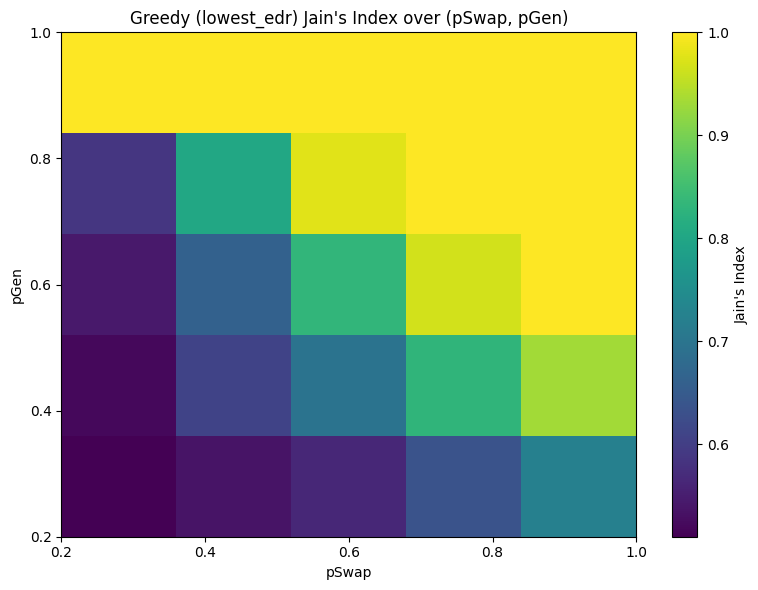

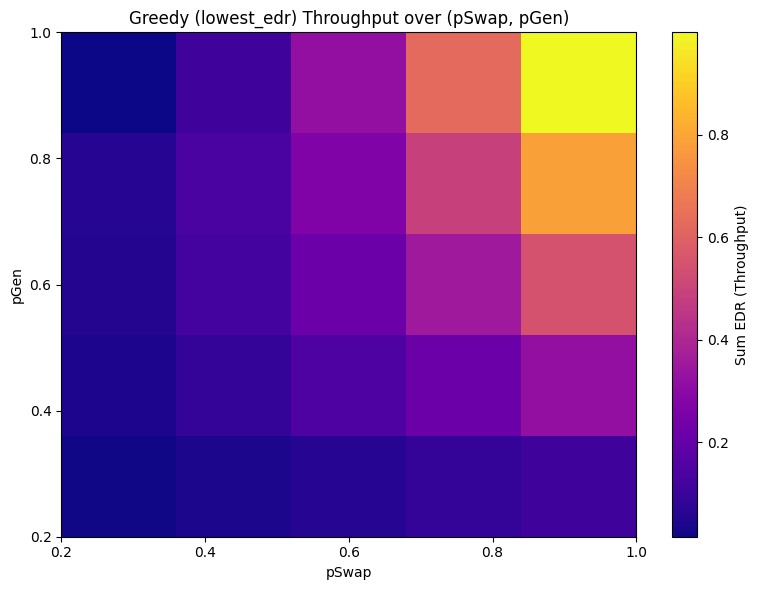

In [66]:
pSwap_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
pGen_values =[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

pSwap_values = [0.2, 0.4, 0.6, 0.8, 1]
pGen_values =[0.2, 0.4, 0.6, 0.8, 1]
pSwap = 0.6
pGen = 0.6
maxAge = 3

num_steps = 50_000
policy = 'lowest_edr'   # 'utility', 'random', 'lowest_edr', etc.
seed = 30
random.seed(seed)
np.random.seed(seed)

# Prepare matrices
jain_matrix = np.zeros((len(pGen_values), len(pSwap_values)))
edr_matrix  = np.zeros((len(pGen_values), len(pSwap_values)))

# --- Loop over (pGen, pSwap) grid ---
for i, pGen_val in enumerate(pGen_values):
    for j, pSwap_val in enumerate(pSwap_values):
        print(f"\n=== Running Greedy for pSwap={pSwap_val}, pGen={pGen_val} ===")
        
        sweep_results = run_greedy_param_sweep(
            edges=edges,
            goalEdges=goal_edges,
            param_name='pSwap',  
            param_values=[pSwap_val],  
            fixed_params={'pGen': pGen_val, 'pSwap': pSwap_val, 'maxAge': maxAge},
            policy=policy,  
            num_steps=num_steps,
            plot=False  
        )

        result = sweep_results[pSwap_val]  # single param_value, direct access

        # --- CORRECT way to extract for Greedy ---
        jain = result['jain']            # directly
        edr_sum = result['throughput']    # directly

        jain_matrix[i, j] = jain
        edr_matrix[i, j] = edr_sum



# --- Now plot heatmaps ---

# (1) Jain's Index Heatmap
plt.figure(figsize=(8,6))
plt.imshow(jain_matrix, origin='lower', cmap='viridis',
           extent=[min(pSwap_values), max(pSwap_values), min(pGen_values), max(pGen_values)],
           aspect='auto')
plt.colorbar(label="Jain's Index")
plt.xlabel('pSwap')
plt.ylabel('pGen')
plt.title(f"Greedy ({policy}) Jain's Index over (pSwap, pGen)")
plt.xticks(pSwap_values)
plt.yticks(pGen_values)
plt.grid(False)
plt.tight_layout()
plt.show()

# (2) EDR Sum (Throughput) Heatmap
plt.figure(figsize=(8,6))
plt.imshow(edr_matrix, origin='lower', cmap='plasma',
           extent=[min(pSwap_values), max(pSwap_values), min(pGen_values), max(pGen_values)],
           aspect='auto')
plt.colorbar(label="Sum EDR (Throughput)")
plt.xlabel('pSwap')
plt.ylabel('pGen')
plt.title(f"Greedy ({policy}) Throughput over (pSwap, pGen)")
plt.xticks(pSwap_values)
plt.yticks(pGen_values)
plt.grid(False)
plt.tight_layout()
plt.show()


In [67]:
print(jain_matrix)
print(edr_matrix)


[[0.51025533 0.53662818 0.56480548 0.63637453 0.72438122]
 [0.52078405 0.6082612  0.69752318 0.82987957 0.93298006]
 [0.54444466 0.66177925 0.83291539 0.96617461 1.        ]
 [0.58824331 0.80428084 0.97755307 1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
[[0.0197  0.03844 0.05728 0.08374 0.11118]
 [0.04222 0.08588 0.14642 0.21826 0.31744]
 [0.05254 0.1215  0.21952 0.35124 0.54676]
 [0.05534 0.13586 0.26608 0.4895  0.78672]
 [0.0158  0.10928 0.31706 0.62358 0.99998]]


In [ ]:
""""
UTILITY
[[0.51025533 0.53660849 0.56480548 0.63637453 0.72438122]
 [0.52076399 0.60831585 0.69746342 0.82977603 0.93293702]
 [0.53949233 0.6535482  0.81861688 0.95373165 0.99999997]
 [0.5397855  0.65588572 0.81869453 0.95398294 1.        ]
 [0.5399361  0.65608503 0.81871159 0.95402714 1.        ]]
[[0.0197  0.03846 0.05728 0.08374 0.11118]
 [0.04226 0.08584 0.14646 0.21818 0.31748]
 [0.05782 0.12298 0.22264 0.35386 0.5469 ]
 [0.08246 0.18544 0.31522 0.51068 0.7876 ]
 [0.10244 0.22914 0.4036  0.65662 0.99998]]
""""

UTILITY
Greedy Jain Matrix:
[[0.51025533 0.53662818 0.56480548 0.63637453 0.72438122]
 [0.52078405 0.6082612  0.69752318 0.82987957 0.93298006]
 [0.54444466 0.66177925 0.83291539 0.96617461 1.        ]
 [0.58824331 0.80428084 0.97755307 1.         1.        ]
 [1.         1.         1.         1.         1.        ]]

Greedy Throughput Matrix:
[[0.0197  0.03844 0.05728 0.08374 0.11118]
 [0.04222 0.08588 0.14642 0.21826 0.31744]
 [0.05254 0.1215  0.21952 0.35124 0.54676]
 [0.05534 0.13586 0.26608 0.4895  0.78672]
 [0.0158  0.10928 0.31706 0.62358 0.99998]]


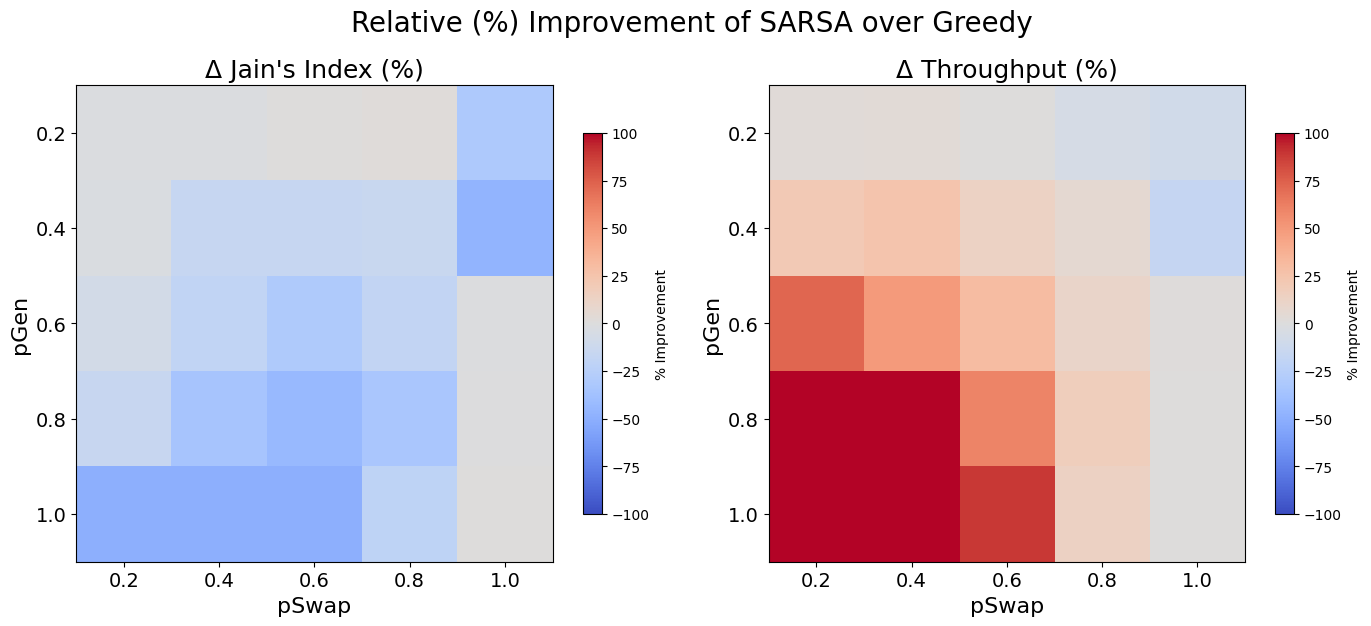

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# === Hardcoded matrices ===
# SARSA results
sarsa_jain = np.array([
    [0.5, 0.52704163, 0.5653287, 0.65032336, 0.5],
    [0.5055372, 0.51313699, 0.58755214, 0.71181663, 0.5],
    [0.50414515, 0.53636279, 0.58118257, 0.78899026, 0.98881581],
    [0.5, 0.52394399, 0.55600171, 0.66795353, 0.9966423],
    [0.5, 0.5, 0.5, 0.79062111, 1.0]
])

sarsa_throughput = np.array([
    [0.02028475, 0.03978548, 0.05766298, 0.07887823, 0.10097255],
    [0.05082624, 0.10731733, 0.16523235, 0.23028179, 0.2645889],
    [0.09035444, 0.18162424, 0.28522811, 0.38695364, 0.55162476],
    [0.13755975, 0.27689112, 0.42574295, 0.57361236, 0.78879176],
    [0.20455935, 0.39913665, 0.59827355, 0.7080442, 0.99999134]
])

# Greedy matrices you asked for
greedy_jain = np.array([
    [0.51025533, 0.53662818, 0.56480548, 0.63637453, 0.72438122],
    [0.52078405, 0.6082612,  0.69752318, 0.82987957, 0.93298006],
    [0.54444466, 0.66177925, 0.83291539, 0.96617461, 1.0],
    [0.58824331, 0.80428084, 0.97755307, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0]
])

greedy_throughput = np.array([
    [0.0197, 0.03844, 0.05728, 0.08374, 0.11118],
    [0.04222, 0.08588, 0.14642, 0.21826, 0.31744],
    [0.05254, 0.1215, 0.21952, 0.35124, 0.54676],
    [0.05534, 0.13586, 0.26608, 0.4895, 0.78672],
    [0.0158, 0.10928, 0.31706, 0.62358, 0.99998]
])

# === Compute relative (%) improvement ===
delta_jain = 100 * (sarsa_jain - greedy_jain) / greedy_jain
delta_throughput = 100 * (sarsa_throughput - greedy_throughput) / greedy_throughput

# === Print statement ===
print("UTILITY")
print("Greedy Jain Matrix:")
print(greedy_jain)
print("\nGreedy Throughput Matrix:")
print(greedy_throughput)

# === Plotting ===
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# (1) Δ Jain's Index (%)
im1 = axs[0].imshow(delta_jain, cmap='coolwarm', vmin=-100, vmax=100)
axs[0].set_title("Δ Jain's Index (%)", fontsize=18)
axs[0].set_xlabel("pSwap", fontsize=16)
axs[0].set_ylabel("pGen", fontsize=16)
plt.colorbar(im1, ax=axs[0], shrink=0.8, label="% Improvement")

# (2) Δ Throughput (%)
im2 = axs[1].imshow(delta_throughput, cmap='coolwarm', vmin=-100, vmax=100)
axs[1].set_title("Δ Throughput (%)", fontsize=18)
axs[1].set_xlabel("pSwap", fontsize=16)
axs[1].set_ylabel("pGen", fontsize=16)
plt.colorbar(im2, ax=axs[1], shrink=0.8, label="% Improvement")

# Formatting ticks
for ax in axs:
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)

plt.suptitle("Relative (%) Improvement of SARSA over Greedy", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
"""
LOWEST EDR
[[0.51025533 0.53662818 0.56480548 0.63637453 0.72438122]
 [0.52078405 0.6082612  0.69752318 0.82987957 0.93298006]
 [0.54444466 0.66177925 0.83291539 0.96617461 1.        ]
 [0.58824331 0.80428084 0.97755307 1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
[[0.0197  0.03844 0.05728 0.08374 0.11118]
 [0.04222 0.08588 0.14642 0.21826 0.31744]
 [0.05254 0.1215  0.21952 0.35124 0.54676]
 [0.05534 0.13586 0.26608 0.4895  0.78672]
 [0.0158  0.10928 0.31706 0.62358 0.99998]]
"""

LOWEST EDR
Greedy Jain Matrix:
[[0.51025533 0.53662818 0.56480548 0.63637453 0.72438122]
 [0.52078405 0.6082612  0.69752318 0.82987957 0.93298006]
 [0.54444466 0.66177925 0.83291539 0.96617461 1.        ]
 [0.58824331 0.80428084 0.97755307 1.         1.        ]
 [1.         1.         1.         1.         1.        ]]

Greedy Throughput Matrix:
[[0.0197  0.03844 0.05728 0.08374 0.11118]
 [0.04222 0.08588 0.14642 0.21826 0.31744]
 [0.05254 0.1215  0.21952 0.35124 0.54676]
 [0.05534 0.13586 0.26608 0.4895  0.78672]
 [0.0158  0.10928 0.31706 0.62358 0.99998]]


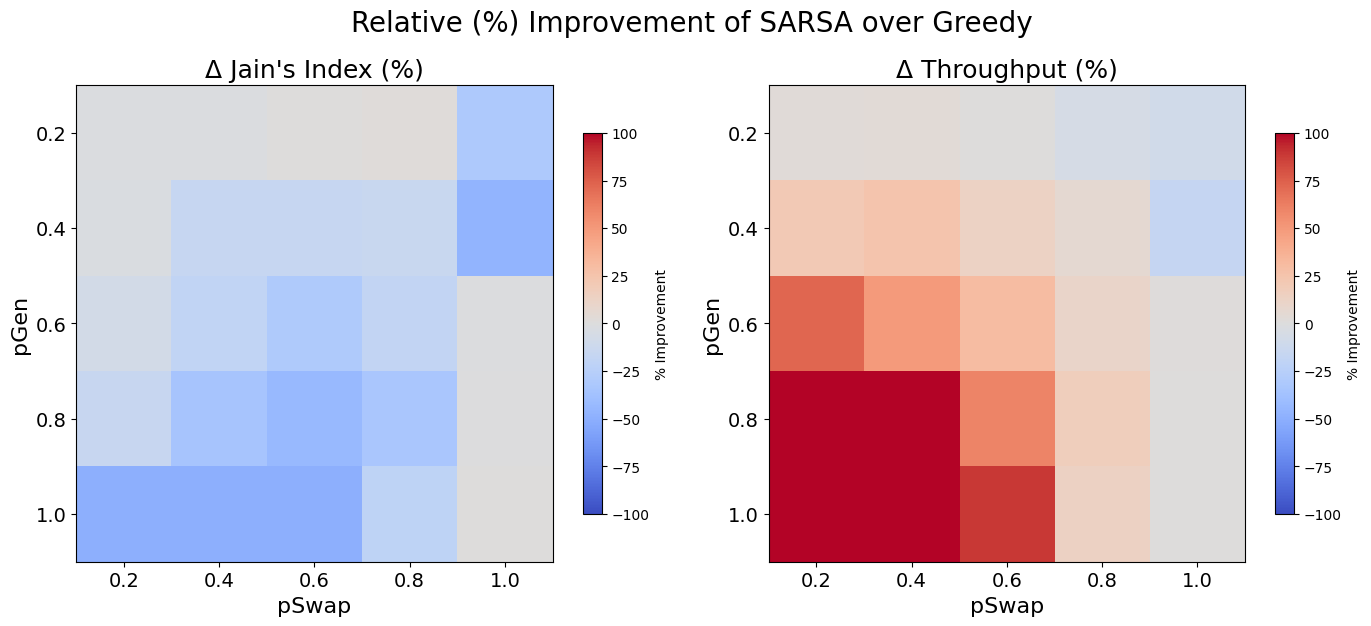

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# === Hardcoded matrices ===
# SARSA results
sarsa_jain = np.array([
    [0.5, 0.52704163, 0.5653287, 0.65032336, 0.5],
    [0.5055372, 0.51313699, 0.58755214, 0.71181663, 0.5],
    [0.50414515, 0.53636279, 0.58118257, 0.78899026, 0.98881581],
    [0.5, 0.52394399, 0.55600171, 0.66795353, 0.9966423],
    [0.5, 0.5, 0.5, 0.79062111, 1.0]
])

sarsa_throughput = np.array([
    [0.02028475, 0.03978548, 0.05766298, 0.07887823, 0.10097255],
    [0.05082624, 0.10731733, 0.16523235, 0.23028179, 0.2645889],
    [0.09035444, 0.18162424, 0.28522811, 0.38695364, 0.55162476],
    [0.13755975, 0.27689112, 0.42574295, 0.57361236, 0.78879176],
    [0.20455935, 0.39913665, 0.59827355, 0.7080442, 0.99999134]
])

# Greedy matrices you provided
greedy_jain = np.array([
    [0.51025533, 0.53662818, 0.56480548, 0.63637453, 0.72438122],
    [0.52078405, 0.6082612,  0.69752318, 0.82987957, 0.93298006],
    [0.54444466, 0.66177925, 0.83291539, 0.96617461, 1.0],
    [0.58824331, 0.80428084, 0.97755307, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0]
])

greedy_throughput = np.array([
    [0.0197, 0.03844, 0.05728, 0.08374, 0.11118],
    [0.04222, 0.08588, 0.14642, 0.21826, 0.31744],
    [0.05254, 0.1215, 0.21952, 0.35124, 0.54676],
    [0.05534, 0.13586, 0.26608, 0.4895, 0.78672],
    [0.0158, 0.10928, 0.31706, 0.62358, 0.99998]
])

# === Compute relative (%) improvement ===
delta_jain = 100 * (sarsa_jain - greedy_jain) / greedy_jain
delta_throughput = 100 * (sarsa_throughput - greedy_throughput) / greedy_throughput

# === Print statement ===
print("LOWEST EDR")
print("Greedy Jain Matrix:")
print(greedy_jain)
print("\nGreedy Throughput Matrix:")
print(greedy_throughput)

# === Plotting ===
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# (1) Δ Jain's Index (%)
im1 = axs[0].imshow(delta_jain, cmap='coolwarm', vmin=-100, vmax=100)
axs[0].set_title("Δ Jain's Index (%)", fontsize=18)
axs[0].set_xlabel("pSwap", fontsize=16)
axs[0].set_ylabel("pGen", fontsize=16)
plt.colorbar(im1, ax=axs[0], shrink=0.8, label="% Improvement")

# (2) Δ Throughput (%)
im2 = axs[1].imshow(delta_throughput, cmap='coolwarm', vmin=-100, vmax=100)
axs[1].set_title("Δ Throughput (%)", fontsize=18)
axs[1].set_xlabel("pSwap", fontsize=16)
axs[1].set_ylabel("pGen", fontsize=16)
plt.colorbar(im2, ax=axs[1], shrink=0.8, label="% Improvement")

# Formatting ticks
for ax in axs:
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)

plt.suptitle("Relative (%) Improvement of SARSA over Greedy", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
print(greedy_results)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Your corrected data ===
# SARSA results
sarsa_jain = np.array([
    [0.5, 0.52704163, 0.5653287, 0.65032336, 0.5],
    [0.5055372, 0.51313699, 0.58755214, 0.71181663, 0.5],
    [0.50414515, 0.53636279, 0.58118257, 0.78899026, 0.98881581],
    [0.5, 0.52394399, 0.55600171, 0.66795353, 0.9966423],
    [0.5, 0.5, 0.5, 0.79062111, 1.0]
])

sarsa_throughput = np.array([
    [0.02028475, 0.03978548, 0.05766298, 0.07887823, 0.10097255],
    [0.05082624, 0.10731733, 0.16523235, 0.23028179, 0.2645889],
    [0.09035444, 0.18162424, 0.28522811, 0.38695364, 0.55162476],
    [0.13755975, 0.27689112, 0.42574295, 0.57361236, 0.78879176],
    [0.20455935, 0.39913665, 0.59827355, 0.7080442, 0.99999134]
])

# NEW Greedy results you provided
greedy_jain = np.array([
    [0.51025533, 0.53662818, 0.56480548, 0.63637453, 0.72438122],
    [0.52078405, 0.6082612,  0.69752318, 0.82987957, 0.93298006],
    [0.54444466, 0.66177925, 0.83291539, 0.96617461, 1.0],
    [0.58824331, 0.80428084, 0.97755307, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0]
])

greedy_throughput = np.array([
    [0.0197, 0.03844, 0.05728, 0.08374, 0.11118],
    [0.04222, 0.08588, 0.14642, 0.21826, 0.31744],
    [0.05254, 0.1215, 0.21952, 0.35124, 0.54676],
    [0.05534, 0.13586, 0.26608, 0.4895, 0.78672],
    [0.0158, 0.10928, 0.31706, 0.62358, 0.99998]
])

import numpy as np
import matplotlib.pyplot as plt

# === Your corrected raw matrices ===
# (you already gave these)
# (same data you sent before)

# === Compute RELATIVE % differences (SARSA vs Greedy) ===
delta_jain = 100 * (sarsa_jain - greedy_jain) / greedy_jain
delta_throughput = 100 * (sarsa_throughput - greedy_throughput) / greedy_throughput

# === Plotting ===
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# (1) Δ Jain's Index (%)
im1 = axs[0].imshow(delta_jain, cmap='coolwarm', vmin=-100, vmax=100)
axs[0].set_title("Δ Jain's Index % (SARSA vs Greedy)")
axs[0].set_xlabel("pSwap")
axs[0].set_ylabel("pGen")
plt.colorbar(im1, ax=axs[0], shrink=0.8, label="% Improvement")

# (2) Δ Throughput (%)
im2 = axs[1].imshow(delta_throughput, cmap='coolwarm', vmin=-100, vmax=100)
axs[1].set_title("Δ Throughput % (SARSA vs Greedy)")
axs[1].set_xlabel("pSwap")
axs[1].set_ylabel("pGen")
plt.colorbar(im2, ax=axs[1], shrink=0.8, label="% Improvement")

# Formatting ticks
for ax in axs:
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])

plt.suptitle("Relative (%) Improvement: SARSA vs Greedy", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Your corrected matrices ---
# SARSA results
sarsa_jain = np.array([
    [0.5, 0.52704163, 0.5653287, 0.65032336, 0.5],
    [0.5055372, 0.51313699, 0.58755214, 0.71181663, 0.5],
    [0.50414515, 0.53636279, 0.58118257, 0.78899026, 0.98881581],
    [0.5, 0.52394399, 0.55600171, 0.66795353, 0.9966423],
    [0.5, 0.5, 0.5, 0.79062111, 1.0]
])

sarsa_throughput = np.array([
    [0.02028475, 0.03978548, 0.05766298, 0.07887823, 0.10097255],
    [0.05082624, 0.10731733, 0.16523235, 0.23028179, 0.2645889],
    [0.09035444, 0.18162424, 0.28522811, 0.38695364, 0.55162476],
    [0.13755975, 0.27689112, 0.42574295, 0.57361236, 0.78879176],
    [0.20455935, 0.39913665, 0.59827355, 0.7080442, 0.99999134]
])

# Greedy results
greedy_jain = np.array([
    [0.51025533, 0.53662818, 0.56480548, 0.63637453, 0.72438122],
    [0.52078405, 0.6082612,  0.69752318, 0.82987957, 0.93298006],
    [0.54444466, 0.66177925, 0.83291539, 0.96617461, 1.0],
    [0.58824331, 0.80428084, 0.97755307, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0]
])

greedy_throughput = np.array([
    [0.0197, 0.03844, 0.05728, 0.08374, 0.11118],
    [0.04222, 0.08588, 0.14642, 0.21826, 0.31744],
    [0.05254, 0.1215, 0.21952, 0.35124, 0.54676],
    [0.05534, 0.13586, 0.26608, 0.4895, 0.78672],
    [0.0158, 0.10928, 0.31706, 0.62358, 0.99998]
])

import numpy as np
import matplotlib.pyplot as plt

# Assume delta_jain and delta_throughput are already computed

# --- Plotting ---
fig, axs = plt.subplots(
    1, 2,
    figsize=(12, 5),
    sharey=True,
    gridspec_kw={'wspace': 0.05}   # <<< even tighter
)

vmin, vmax = -100, 100  # consistent color scale

# (1) Jain's Index
im1 = axs[0].imshow(delta_jain, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0].set_title("Jain's Index", fontsize=14, pad=12)
axs[0].set_xlabel("pSwap")
axs[0].set_ylabel("pGen")
axs[0].set_xticks(range(5))
axs[0].set_yticks(range(5))
axs[0].set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
axs[0].set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
axs[0].grid(False)

# (2) Throughput
im2 = axs[1].imshow(delta_throughput, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[1].set_title("Throughput", fontsize=14, pad=12)
axs[1].set_xlabel("pSwap")
axs[1].set_xticks(range(5))
axs[1].set_yticks(range(5))
axs[1].set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
axs[1].set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
axs[1].grid(False)

# --- Shared horizontal colorbar ---
cbar_ax = fig.add_axes([0.25, 0.98, 0.5, 0.035])  # <<< pushed higher!
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label("Relative Improvement (%)", fontsize=12, labelpad=8)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()



/var/folders/gg/2xgfrwhs60j8qg5zm5gbky_c0000gn/T/ipykernel_26060/2956800340.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.9])


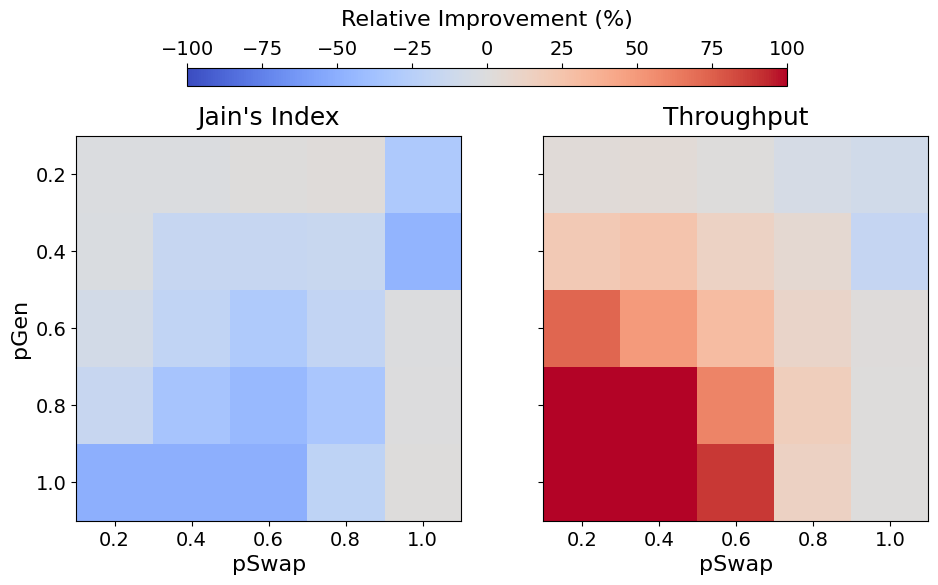

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Assume delta_jain and delta_throughput are already computed
# --- Plotting ---
fig, axs = plt.subplots(
    1, 2,
    figsize=(12, 5),
    sharey=True,
    gridspec_kw={'wspace': 0.01}  # tight plots
)

vmin, vmax = -100, 100  # consistent color scale

# (1) Jain's Index
im1 = axs[0].imshow(delta_jain, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0].set_title("Jain's Index", fontsize=18, pad=8)  # <<< bigger title
axs[0].set_xlabel("pSwap", fontsize=16)
axs[0].set_ylabel("pGen", fontsize=16)
axs[0].set_xticks(range(5))
axs[0].set_yticks(range(5))
axs[0].set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
axs[0].set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
axs[0].grid(False)

# (2) Throughput
im2 = axs[1].imshow(delta_throughput, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[1].set_title("Throughput", fontsize=18, pad=8)  # <<< bigger title
axs[1].set_xlabel("pSwap", fontsize=16)
axs[1].set_xticks(range(5))
axs[1].set_yticks(range(5))
axs[1].set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
axs[1].set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
axs[1].grid(False)

# --- Shared colorbar ---
cbar_ax = fig.add_axes([0.25, 0.98, 0.5, 0.035])  # high and thick
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label("Relative Improvement (%)", fontsize=16, labelpad=10)
cbar.ax.tick_params(labelsize=14)  # <<< THIS LINE to control number size

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()



/var/folders/gg/2xgfrwhs60j8qg5zm5gbky_c0000gn/T/ipykernel_26060/1570702231.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.9])


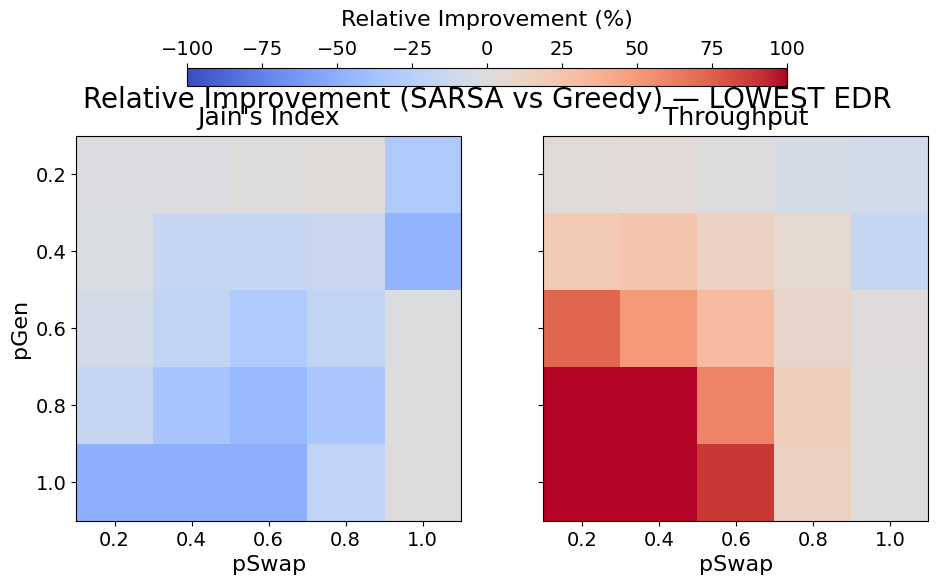

/var/folders/gg/2xgfrwhs60j8qg5zm5gbky_c0000gn/T/ipykernel_26060/1570702231.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.9])


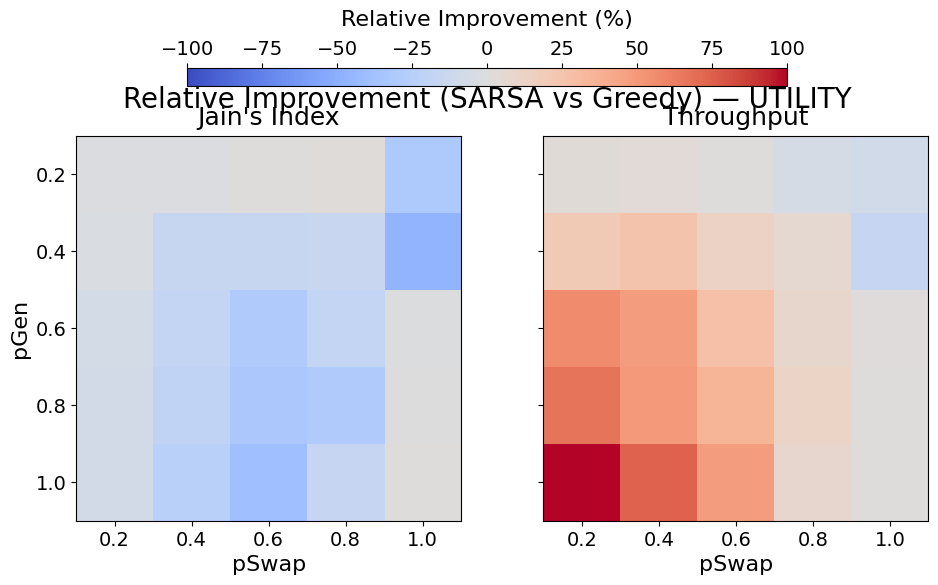

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# === SARSA Results ===
sarsa_jain = np.array([
    [0.5, 0.52704163, 0.5653287, 0.65032336, 0.5],
    [0.5055372, 0.51313699, 0.58755214, 0.71181663, 0.5],
    [0.50414515, 0.53636279, 0.58118257, 0.78899026, 0.98881581],
    [0.5, 0.52394399, 0.55600171, 0.66795353, 0.9966423],
    [0.5, 0.5, 0.5, 0.79062111, 1.0]
])

sarsa_throughput = np.array([
    [0.02028475, 0.03978548, 0.05766298, 0.07887823, 0.10097255],
    [0.05082624, 0.10731733, 0.16523235, 0.23028179, 0.2645889],
    [0.09035444, 0.18162424, 0.28522811, 0.38695364, 0.55162476],
    [0.13755975, 0.27689112, 0.42574295, 0.57361236, 0.78879176],
    [0.20455935, 0.39913665, 0.59827355, 0.7080442, 0.99999134]
])

# === Greedy LOWEST EDR ===
greedy_jain_lowest = np.array([
    [0.51025533, 0.53662818, 0.56480548, 0.63637453, 0.72438122],
    [0.52078405, 0.6082612,  0.69752318, 0.82987957, 0.93298006],
    [0.54444466, 0.66177925, 0.83291539, 0.96617461, 1.0],
    [0.58824331, 0.80428084, 0.97755307, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0]
])

greedy_throughput_lowest = np.array([
    [0.0197, 0.03844, 0.05728, 0.08374, 0.11118],
    [0.04222, 0.08588, 0.14642, 0.21826, 0.31744],
    [0.05254, 0.1215, 0.21952, 0.35124, 0.54676],
    [0.05534, 0.13586, 0.26608, 0.4895, 0.78672],
    [0.0158, 0.10928, 0.31706, 0.62358, 0.99998]
])

# === Greedy UTILITY ===
greedy_jain_utility = np.array([
    [0.51025533, 0.53660849, 0.56480548, 0.63637453, 0.72438122],
    [0.52076399, 0.60831585, 0.69746342, 0.82977603, 0.93293702],
    [0.53949233, 0.6535482,  0.81861688, 0.95373165, 0.99999997],
    [0.5397855, 0.65588572, 0.81869453, 0.95398294, 1.0],
    [0.5399361, 0.65608503, 0.81871159, 0.95402714, 1.0]
])

greedy_throughput_utility = np.array([
    [0.0197, 0.03846, 0.05728, 0.08374, 0.11118],
    [0.04226, 0.08584, 0.14646, 0.21818, 0.31748],
    [0.05782, 0.12298, 0.22264, 0.35386, 0.5469],
    [0.08246, 0.18544, 0.31522, 0.51068, 0.7876],
    [0.10244, 0.22914, 0.4036, 0.65662, 0.99998]
])

# ========== Compact Plot Function ==========
def compact_plot(title_tag, greedy_jain, greedy_throughput):
    delta_jain = 100 * (sarsa_jain - greedy_jain) / greedy_jain
    delta_throughput = 100 * (sarsa_throughput - greedy_throughput) / greedy_throughput

    fig, axs = plt.subplots(
        1, 2, figsize=(12, 5), sharey=True,
        gridspec_kw={'wspace': 0.01}
    )

    vmin, vmax = -100, 100

    # (1) Jain
    im1 = axs[0].imshow(delta_jain, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axs[0].set_title("Jain's Index", fontsize=18, pad=8)
    axs[0].set_xlabel("pSwap", fontsize=16)
    axs[0].set_ylabel("pGen", fontsize=16)
    axs[0].set_xticks(range(5))
    axs[0].set_yticks(range(5))
    axs[0].set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    axs[0].set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    axs[0].grid(False)

    # (2) Throughput
    im2 = axs[1].imshow(delta_throughput, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axs[1].set_title("Throughput", fontsize=18, pad=8)
    axs[1].set_xlabel("pSwap", fontsize=16)
    axs[1].set_xticks(range(5))
    axs[1].set_yticks(range(5))
    axs[1].set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    axs[1].set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    axs[1].grid(False)

    # --- Shared colorbar ---
    cbar_ax = fig.add_axes([0.25, 0.98, 0.5, 0.035])
    cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label("Relative Improvement (%)", fontsize=16, labelpad=10)
    cbar.ax.tick_params(labelsize=14)

    plt.suptitle(f"Relative Improvement (SARSA vs Greedy) — {title_tag}", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

# ===== Plot LOWEST EDR =====
compact_plot("LOWEST EDR", greedy_jain_lowest, greedy_throughput_lowest)

# ===== Plot UTILITY =====
compact_plot("UTILITY", greedy_jain_utility, greedy_throughput_utility)


/var/folders/gg/2xgfrwhs60j8qg5zm5gbky_c0000gn/T/ipykernel_26060/3130622708.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.9])


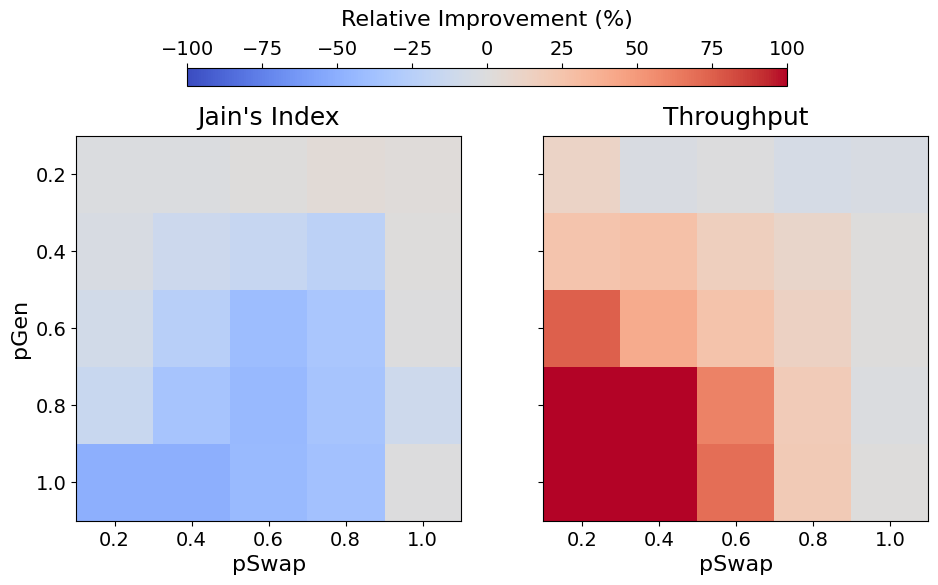

/var/folders/gg/2xgfrwhs60j8qg5zm5gbky_c0000gn/T/ipykernel_26060/3130622708.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.9])


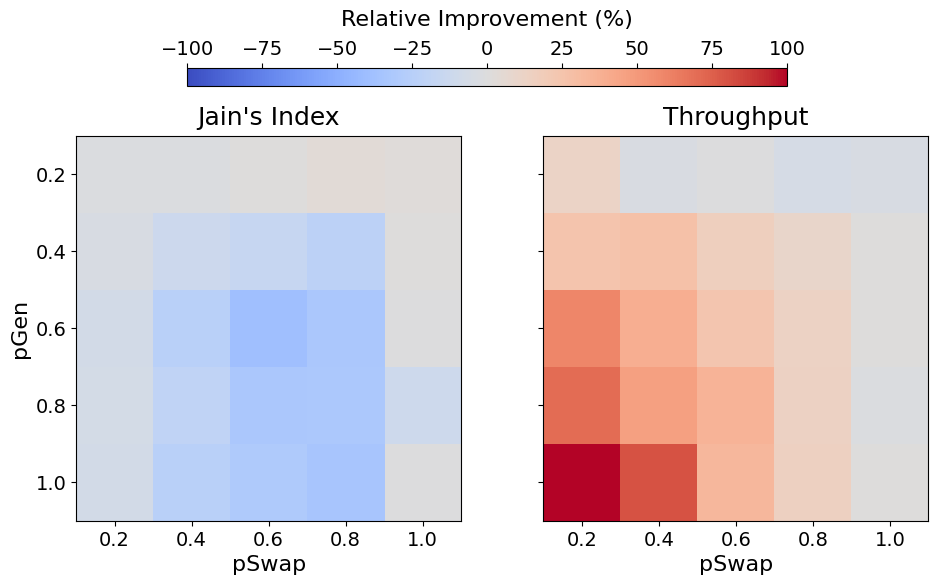

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# === Q-LEARNING Results ===
qlearning_jain = np.array([
    [0.5, 0.5281832, 0.56688655, 0.65664541, 0.73837336],
    [0.5, 0.5358237, 0.58503671, 0.64294107, 0.93545963],
    [0.5, 0.5, 0.5, 0.64510312, 0.99889798],
    [0.50443058, 0.52342995, 0.55574278, 0.6503786, 0.8842256],
    [0.5, 0.5, 0.57110471, 0.62656899, 0.99916059]
])

qlearning_throughput = np.array([
    [0.0221372, 0.03715113, 0.05686215, 0.07881783, 0.10633009],
    [0.0527652, 0.10877192, 0.16984705, 0.23922145, 0.31978126],
    [0.0919334, 0.1701, 0.2753194, 0.40062305, 0.54778923],
    [0.13981655, 0.27224971, 0.42779234, 0.5814286, 0.77383925],
    [0.2069652, 0.411963, 0.53696571, 0.74970215, 0.99998688]
])

# === Greedy LOWEST EDR ===
greedy_jain_lowest = np.array([
    [0.51025533, 0.53662818, 0.56480548, 0.63637453, 0.72438122],
    [0.52078405, 0.6082612,  0.69752318, 0.82987957, 0.93298006],
    [0.54444466, 0.66177925, 0.83291539, 0.96617461, 1.0],
    [0.58824331, 0.80428084, 0.97755307, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0]
])

greedy_throughput_lowest = np.array([
    [0.0197, 0.03844, 0.05728, 0.08374, 0.11118],
    [0.04222, 0.08588, 0.14642, 0.21826, 0.31744],
    [0.05254, 0.1215, 0.21952, 0.35124, 0.54676],
    [0.05534, 0.13586, 0.26608, 0.4895, 0.78672],
    [0.0158, 0.10928, 0.31706, 0.62358, 0.99998]
])

# === Greedy UTILITY ===
greedy_jain_utility = np.array([
    [0.51025533, 0.53660849, 0.56480548, 0.63637453, 0.72438122],
    [0.52076399, 0.60831585, 0.69746342, 0.82977603, 0.93293702],
    [0.53949233, 0.6535482,  0.81861688, 0.95373165, 0.99999997],
    [0.5397855, 0.65588572, 0.81869453, 0.95398294, 1.0],
    [0.5399361, 0.65608503, 0.81871159, 0.95402714, 1.0]
])

greedy_throughput_utility = np.array([
    [0.0197, 0.03846, 0.05728, 0.08374, 0.11118],
    [0.04226, 0.08584, 0.14646, 0.21818, 0.31748],
    [0.05782, 0.12298, 0.22264, 0.35386, 0.5469],
    [0.08246, 0.18544, 0.31522, 0.51068, 0.7876],
    [0.10244, 0.22914, 0.4036, 0.65662, 0.99998]
])

# ========== Compact Plot Function ==========
def compact_plot(title_tag, greedy_jain, greedy_throughput):
    delta_jain = 100 * (qlearning_jain - greedy_jain) / greedy_jain
    delta_throughput = 100 * (qlearning_throughput - greedy_throughput) / greedy_throughput

    fig, axs = plt.subplots(
        1, 2, figsize=(12, 5), sharey=True,
        gridspec_kw={'wspace': 0.01}
    )

    vmin, vmax = -100, 100

    # (1) Jain
    im1 = axs[0].imshow(delta_jain, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axs[0].set_title("Jain's Index", fontsize=18, pad=8)
    axs[0].set_xlabel("pSwap", fontsize=16)
    axs[0].set_ylabel("pGen", fontsize=16)
    axs[0].set_xticks(range(5))
    axs[0].set_yticks(range(5))
    axs[0].set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    axs[0].set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    axs[0].grid(False)

    # (2) Throughput
    im2 = axs[1].imshow(delta_throughput, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axs[1].set_title("Throughput", fontsize=18, pad=8)
    axs[1].set_xlabel("pSwap", fontsize=16)
    axs[1].set_xticks(range(5))
    axs[1].set_yticks(range(5))
    axs[1].set_xticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    axs[1].set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)
    axs[1].grid(False)

    # --- Shared colorbar ---
    cbar_ax = fig.add_axes([0.25, 0.98, 0.5, 0.035])
    cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label("Relative Improvement (%)", fontsize=16, labelpad=10)
    cbar.ax.tick_params(labelsize=14)

    #plt.suptitle(f"Relative Improvement (Q-Learning vs Greedy) — {title_tag}", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

# ===== Plot LOWEST EDR =====
compact_plot("LOWEST EDR", greedy_jain_lowest, greedy_throughput_lowest)

# ===== Plot UTILITY =====
compact_plot("UTILITY", greedy_jain_utility, greedy_throughput_utility)
